In [7]:
import numpy
import matplotlib.pyplot as plt

In [8]:
# Flare rate from Hilton et al. 2011 for "M3-M5 Active" sample. Energies are in log(E) in Johnson U-band.
hilton_alpha = 15.70
hilton_alpha_err = 1.2
hilton_beta = -0.53
hilton_beta_err = 0.04
hilton_emin = 29.41
hilton_emax = 33.58
# Generate array of x and y values based on the min. and max. energy ranges from the source, and the linear relation
# they report for the FFD.
hilton_xvals = numpy.linspace(hilton_emin, hilton_emax, 50)
hilton_yvals = [hilton_alpha + hilton_beta*x for x in hilton_xvals]

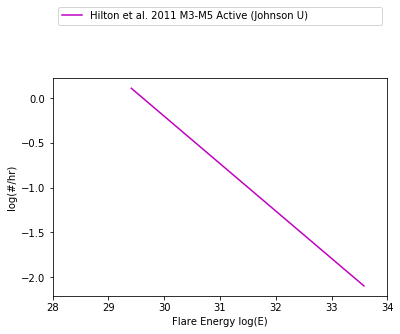

In [10]:
# Plot FFD for each group's results.
fig, ax = plt.subplots(1)
# Plot Hilton et al. FFD relation.
ax.plot(hilton_xvals, hilton_yvals, color='m', label="Hilton et al. 2011 M3-M5 Active (Johnson U)")

# Refine plot ranges.
ax.set_xlim([28., 34.])
ax.set_xlabel("Flare Energy log(E)")
ax.set_ylabel("log(#/hr)")
ax.legend(loc="upper center", bbox_to_anchor=(0.0,1.25,1.,0.102), ncol=2, mode="expand")
plt.show()